In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.io, scipy.special, scipy.optimize

In [15]:
ex4data1 = scipy.io.loadmat("ex4data1.mat")
ex4weights = scipy.io.loadmat("ex4weights.mat")

X_data = ex4data1['X']
y_data = ex4data1['y'].reshape(5000)
X_bitmap = X_data.reshape(5000, 20, 20, order='F')
theta1_pretrained = ex4weights['Theta1'].transpose()
theta2_pretrained = ex4weights['Theta2'].transpose()
num_samples = X_data.shape[0]
num_hidden = 25
num_classes = 10

def plot_digit(n):
    plt.imshow(X_bitmap[n], cmap='binary', interpolation='bicubic')

Convert $y$ from a vector of class labels `y_data`$=\begin{pmatrix}1\\2\\ \vdots\end{pmatrix}$ to a matrix with each row a basis vector corresponding to each class `y_matrix`$=\begin{bmatrix}\left(1, 0, \ldots, 0\right)\\\left(0, 1, \ldots, 0\right)\\ \vdots\end{bmatrix}$

In [16]:
y_tiled = np.tile(y_data,(10,1))
class_tiled = np.tile(np.arange(1, 11), (5000, 1)).transpose()
y_matrix = np.isclose(y_tiled, class_tiled).astype(int).transpose()
print(y_matrix[-1])
print(y_data[-1])
print(theta1_pretrained.shape)
print(theta2_pretrained.shape)

[0 0 0 0 0 0 0 0 1 0]
9
(401, 25)
(26, 10)


Initialize the weight matrices with random entries in $(-\epsilon_{\text{init}},\epsilon_{\text{init}}]$

In [17]:
epsilon_init = 0.12
theta1_init = 2*epsilon_init*np.random.rand(X_data.shape[1] + 1, num_hidden) - epsilon_init
theta2_init = 2*epsilon_init*np.random.rand(num_hidden + 1, num_classes) - epsilon_init
theta_vec_init = np.append(theta1_init.ravel(), theta2_init.ravel())

In [18]:
def nn_feedforward(theta1, theta2, x):
    # input layer: add bias node to input data
    a1 = np.insert(x, 0, 1, axis=1)
    # hidden layer: compute activation function and add bias
    z2 = a1.dot(theta1)
    a2 = np.insert(scipy.special.expit(z2), 0, 1, axis=1)
    # output layer
    a3 = scipy.special.expit(a2.dot(theta2))
    return a3
h = nn_feedforward

In [19]:
nn_feedforward(theta1_init, theta2_init, X_data[1:2])

array([[0.46352065, 0.46273085, 0.57417934, 0.45032168, 0.50975914,
        0.45651282, 0.53494788, 0.50516343, 0.52566781, 0.43452832]])

In [20]:
def nn_cost(theta1, theta2, X, y):
    m = X.shape[0]
    summand = -np.multiply(y, np.log(h(theta1, theta2, X))) -np.multiply((1-y), np.log1p(-h(theta1, theta2, X)))
    return 1/m*np.sum(summand)

In [21]:
nn_cost(theta1_pretrained, theta2_pretrained, X_data, y_matrix)

0.2876291651613189

In [22]:
def nn_cost_reg(theta1, theta2, X, y, lambda_reg):
    m = X.shape[0]
    summand = -np.multiply(y, np.log(h(theta1, theta2, X))) -np.multiply((1-y), np.log1p(-h(theta1, theta2, X)))
    reg_term = lambda_reg/(2)*(np.sum(np.square(theta1)) + np.sum(np.square(theta2)))
    return 1/m*(np.sum(summand) + reg_term)

In [23]:
nn_cost_reg(theta1_pretrained, theta2_pretrained, X_data, y_matrix, 1)

0.384487796242894

In [24]:
def expit_grad(z):
    return np.multiply(scipy.special.expit(z), 1-scipy.special.expit(z))

In [25]:
def nn_backprop_gradient(theta1, theta2, X, y, reg_lambda):
    # feedforward pass
    m = X.shape[0]
    a1 = np.insert(X, 0, 1, axis=1)
    z2 = a1.dot(theta1)
    a2 = np.insert(scipy.special.expit(z2), 0, 1, axis=1)
    a3 = scipy.special.expit(a2.dot(theta2))
    
    # compute errors
    delta3 = a3 - y
    delta2 = np.multiply(expit_grad(z2), np.dot(delta3, theta2[1:,:].transpose()))
    
    # compute gradients
    Delta1 = delta2.transpose().dot(a1)
    Delta2 = delta3.transpose().dot(a2)
    
    theta1[:, 0] = 0
    theta2[:, 0] = 0
    
    D1 = Delta1/m
    D2 = Delta2/m
    
    grad1 = D1 + reg_lambda/m*theta1.transpose()
    grad2 = D2 + reg_lambda/m*theta2.transpose()
    
    return np.append(grad1.ravel(), grad2.ravel())

In [26]:
def nn_cost_unrolled(theta, X, y, reg_lambda):
    num_feature = X.shape[1]
    num_sample = X.shape[0]
    num_classes = y.shape[1]
    t1 = theta[:num_hidden*(num_feature+1)].reshape(num_hidden, num_feature + 1).transpose()
    t2 = theta[num_hidden*(num_feature+1):].reshape(num_classes, num_hidden + 1).transpose()
    return nn_cost_reg(t1, t2, X, y, reg_lambda)

In [27]:
def nn_gradient_unrolled(theta, X, y, reg_lambda):
    num_feature = X.shape[1]
    num_sample = X.shape[0]
    num_classes = y.shape[1]
    t1 = theta[:num_hidden*(num_feature+1)].reshape(num_hidden, num_feature + 1).transpose()
    t2 = theta[num_hidden*(num_feature+1):].reshape(num_classes, num_hidden + 1).transpose()
    return nn_backprop_gradient(t1, t2, X, y, reg_lambda)

In [28]:
theta_min = scipy.optimize.fmin_cg(lambda t: nn_cost_unrolled(t, X_data, y_matrix, 1),
                    fprime=lambda t: nn_gradient_unrolled(t, X_data, y_matrix, 1),
                    x0=theta_vec_init)

         Current function value: 0.371277
         Iterations: 105
         Function evaluations: 287
         Gradient evaluations: 276


In [29]:
theta1_min = theta_min[:10025].reshape(25, 401)
theta2_min = theta_min[10025:].reshape(10, 26)

In [30]:
nn_predicted = nn_feedforward(theta1_min.transpose(), theta2_min.transpose(), X_data)

In [31]:
hidden_unit_bitmaps = theta1_min[:,:-1].reshape(25, 20, 20)

/opt/local/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


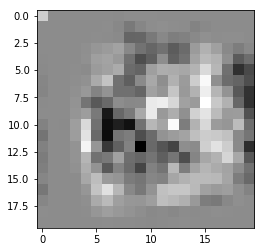

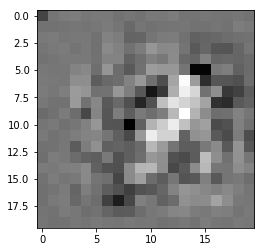

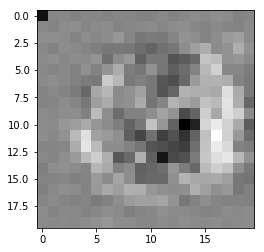

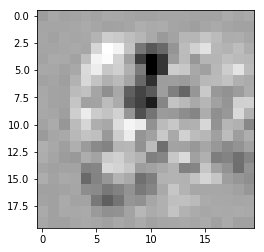

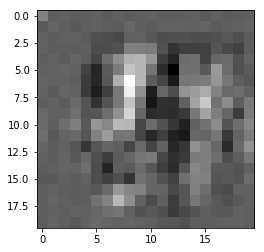

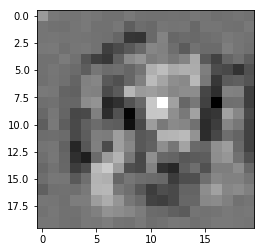

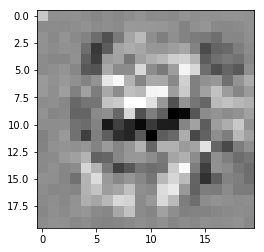

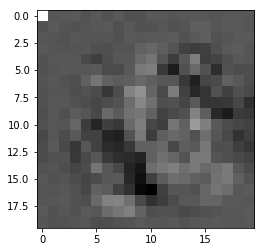

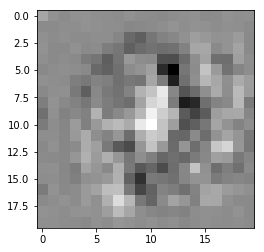

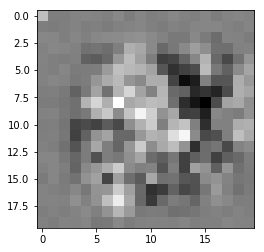

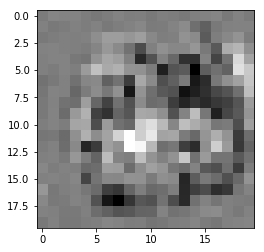

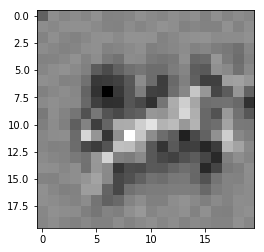

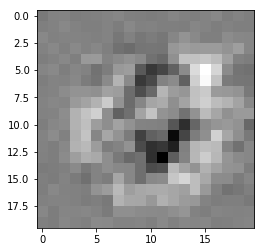

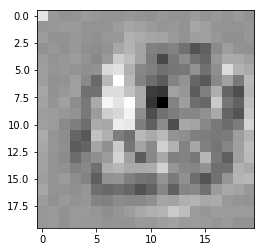

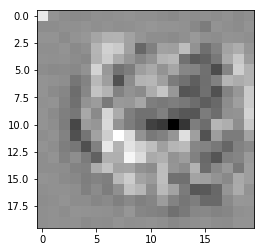

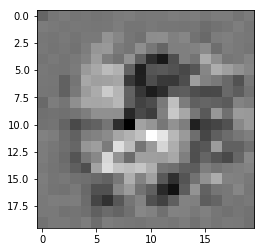

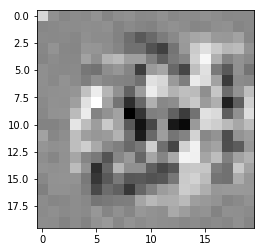

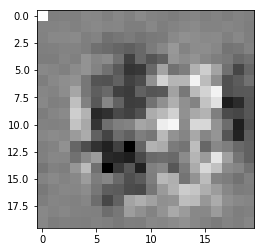

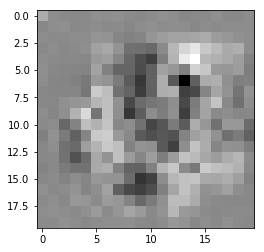

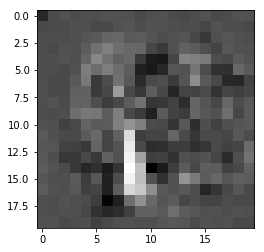

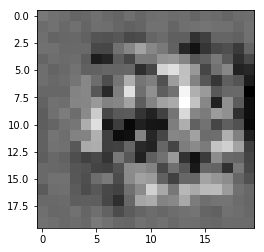

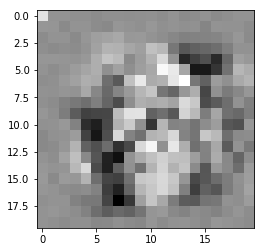

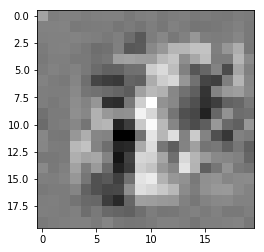

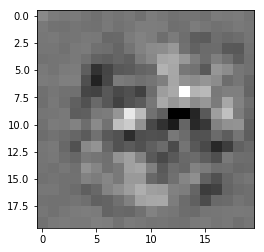

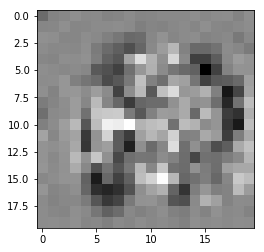

In [32]:
for h in hidden_unit_bitmaps:
    plt.figure()
    plt.imshow(h, cmap='binary')